### Problem Description


sentimental analysis on Amazon Food Review dataset

dataset link:https://www.kaggle.com/snap/amazon-fine-food-reviews?select=Reviews.csv

1-Cleaning Text

Stop words Removal

Text Normalization (Lemmatization) 

2-Text Embedding

BOW, TF-IDF or Word2vec

3-Target Variable 

Score < 3  Negative

Score >=  Positive

4-Use ML Model to classify given food review, whether its negative or positive

5- Save your model as a pickle file for deployment

6-Deployment Use Streamlit framework to create a simple GUI that takes input the food review and returns whether it’s a positive or negative review.

### Import Packages

In [1]:
pip install -U gensim

Requirement already up-to-date: gensim in c:\users\moham\anaconda3\lib\site-packages (4.0.1)
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Add environment Packages paths to conda
import os, sys
# env_name = "food_review"
# sys.path.append(f"C:\\Environments\\{env_name}\\lib\\site-packages\\")

import pandas as pd
import numpy as np

# Text preprocessing packages
import nltk # Text libarary
# nltk.download('stopwords')
import string # Removing special characters {#, @, ...}
import re # Regex Package
from nltk.corpus import stopwords # Stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer # Stemmer & Lemmatizer
from gensim.utils import simple_preprocess  # Text ==> List of Tokens

# Text Embedding
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Saving Model
import pickle

# Visualization Packages
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)
%matplotlib inline

### Read Dataset

In [5]:
%%time
df = pd.read_csv('Reviews.csv')

Wall time: 2.91 s


In [6]:
f"{df.shape[0]:,} Review"

'568,454 Review'

In [7]:
cols = ['Text', 'Score']
df_text = df[cols].copy()
df_text.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


### Drop Duplicates
Save the Cleaned data-frame also with the variable `df_text`

In [8]:
df_text = df_text.drop_duplicates()

In [9]:
df_text = df_text.reset_index(drop=True)

In [10]:
df_text

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5
...,...,...
393670,Great for sesame chicken..this is a good if no...,5
393671,I'm disappointed with the flavor. The chocolat...,2
393672,"These stars are small, so you can give 10-15 o...",5
393673,These are the BEST treats for training and rew...,5


### Target Variable Pre-Processing
`target` will be 
 - 0 if score < 3 
 - 1 otherwise

In [11]:
df_text['target'] =np.where(df_text['Score']<3 ,0,1)
df_text

,Text,Score,target
0,I have bought several of the Vitality canned d...,5,1
1,Product arrived labeled as Jumbo Salted Peanut...,1,0
2,This is a confection that has been around a fe...,4,1
3,If you are looking for the secret ingredient i...,2,0
4,Great taffy at a great price. There was a wid...,5,1
...,...,...,...
393670,Great for sesame chicken..this is a good if no...,5,1
393671,I'm disappointed with the flavor. The chocolat...,2,0
393672,"These stars are small, so you can give 10-15 o...",5,1
393673,These are the BEST treats for training and rew...,5,1


#### Plot Countplot for target Variable

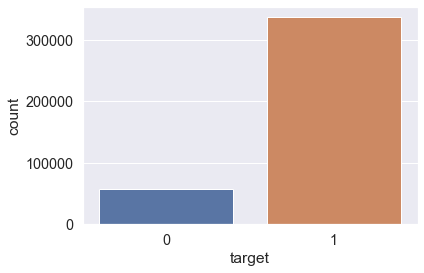

In [12]:
ax = sns.countplot(x="target", data=df_text)


Notice how such variance is huge ...   
Then we need to down-sample such data ... by which both the positive and negative classes are balanced.

### Balance Data Target

In [13]:
# Sample from positive reviews Same number of negative reviews
NEG_N = df_text.target.value_counts()[0]
df_pos = df_text[df_text['target'] == 1]['Text'].sample(NEG_N, replace=False)
df_text_balanced = pd.concat([df_text.iloc[df_pos.index], df_text[df_text.target == 0]])

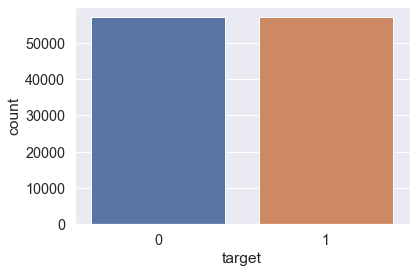

In [14]:
ax = sns.countplot(x="target", data=df_text_balanced)


### Text Pre-Processing

In [33]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")
lemmatizer= WordNetLemmatizer()

In [17]:
df_text_balanced['Text']=df_text_balanced['Text'].str.lower()

In [18]:
df_text_balanced['clean']=df_text_balanced['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in(stop_words)]))

In [19]:
df_text_balanced['lemmaize'] = df_text_balanced['clean'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x.split()])

In [20]:
df_text_balanced

,Text,Score,target,clean,lemmaize
307436,i have just begun my endeavors in making yello...,5,1,begun endeavors making yellow coconut curry th...,"[begun, endeavor, making, yellow, coconut, cur..."
367713,this is the best chocolate mint coffee i have ...,5,1,"best chocolate mint coffee ever tasted! rich, ...","[best, chocolate, mint, coffee, ever, tasted!,..."
32496,these are really tremendous. excellent crunch...,5,1,"really tremendous. excellent crunch flavor, am...","[really, tremendous., excellent, crunch, flavo..."
220418,tasty and not too difficult to eat on the run....,5,1,tasty difficult eat run. use every run longer ...,"[tasty, difficult, eat, run., use, every, run,..."
141811,"ok, there are few things that cannot be improv...",4,1,"ok, things cannot improved coating chocolate. ...","[ok,, thing, cannot, improved, coating, chocol..."
...,...,...,...,...,...
393654,i just bought this soup today at my local groc...,1,0,"bought soup today local grocer, brought back w...","[bought, soup, today, local, grocer,, brought,..."
393655,this soup is mostly broth. although it has a k...,2,0,"soup mostly broth. although kick it, also swee...","[soup, mostly, broth., although, kick, it,, al..."
393656,"it is mostly broth, with the advertised 3/4 cu...",2,0,"mostly broth, advertised 3/4 cup vegetables. h...","[mostly, broth,, advertised, 3/4, cup, vegetab..."
393667,i had ordered some of these a few months back ...,2,0,"ordered months back great, latest batch terrib...","[ordered, month, back, great,, latest, batch, ..."


In [21]:
df_text_balanced['lemmaize']=[" ".join(review) for review in df_text_balanced['lemmaize'].values]

### Split Test & Training Data

In [22]:
X = df_text_balanced['lemmaize'] ## Write your code here
y = df_text_balanced['target'] ## Write your code here
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Text Embedding
 - Use `TfidfVectorizer`
 - `fit` on the training data only
 - `transform` on training and test 

In [23]:
## TFIDF embedding for the Description
vectorizer = TfidfVectorizer()
vectorizer_tfidf = vectorizer.fit(X)
X_train=vectorizer_tfidf.transform(X_train)
X_test = vectorizer_tfidf.transform(X_test)

In [24]:
# See the dimensions of your data embeddings before entering to the model
X_train.shape, X_test.shape

((79917, 65297), (34251, 65297))

### Modelling

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

##### Sklearn framework steps
 - init
 - fit
 - predict

In [43]:
## initialize your Model
clf = RandomForestClassifier()
# Fit your Model on the Training Dataset
clf.fit(X_train,y_train)
# Predict on Test data
preds = clf.predict(X_test)
# Calculate Model Accuracy
acc = accuracy_score(preds, y_test)
print(f"Model Accuracy = {round(acc*100,2)}%")


Model Accuracy = 84.46%


In [44]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [53]:
import string
def remove_punctuation(text):
    punctuation="".join([i for i in text if i not in string.punctuation])
    return punctuation.lower()

In [54]:
def remove_stopwords(text):
    stopwords=" ".join([ x for x in text.split() if x not in stop_words])
    return stopwords

In [55]:
def lemmetizee(text):
    lemmatizer = WordNetLemmatizer()
    word_list = nltk.word_tokenize(text)
    lemmatized = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized

### Raw Instance Prediction

In [56]:
def raw_test(review, model, vectorizer):
    # Clean Review.split()
    review_c = remove_punctuation(remove_stopwords(lemmetizee(review)))
        # Embed review using tf-idf vectorizer
    embedding = vectorizer.transform([review_c])
    # Predict using your model
    prediction = model.predict(embedding)
    # Return the Sentiment Prediction
    return "Positive" if prediction == 1 else "Negative"

In [57]:
review_1 = "That's a good Dish, Good Job"
review_2 = "That's the worst Dish ever tasted"

In [58]:
raw_test(review_1, clf, vectorizer_tfidf)

'Positive'

In [59]:
raw_test(review_2, clf, vectorizer_tfidf)

'Negative'

### Saving Models for Deployment

In [60]:
import pickle

In [61]:
model_name = 'rf_model.pk'
vectorizer_name = 'tfidf_vectorizer.pk'
model_path = os.path.join('/', model_name)
vect_path = os.path.join('/', vectorizer_name)

pickle.dump(clf, open(model_name, 'wb'))
pickle.dump(vectorizer_tfidf, open(vectorizer_name, 'wb'))
... ## Save model
... ## Save tfidf-vectorizer

Ellipsis

### Load model Again and test them

In [62]:
loaded_model = pickle.load(open(model_name, 'rb'))
loaded_vect = pickle.load(open(vectorizer_name, 'rb'))

In [63]:
raw_test(review_1, loaded_model, loaded_vect)

'Positive'

In [64]:
raw_test(review_2, loaded_model, loaded_vect)

'Negative'

# Great Job !
### Now Deploy your ML model using Streamlit Framework